<img src="assets/cyberbully2.jpg"> 


# Toxic Comments Classification Challenge

### Big Data and Brews

**July 7, 2018**


In this social media era, many businesses are moving to incorporate user interaction and discussion in their platforms. However, a minority of users use the technology inappropriately, using it to threaten, insult, or create a generally toxic atmosphere. 

We work to classify these toxic comments, without censoring the population as a whole. 

We investigate ~160,000 comments, about **89.8%** are normal user interaction, and **10.2%** are toxic. The comments are classified in the following 6 ways: 
 * Toxic
 * Severely toxic
 * Obscene
 * Insult
 * Threat
 * Identity hate

Many toxic comments are classified with more than one label. The labels have been classified by human raters. 

A link to the challenge can be found here: 
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data


In [1]:
import re 
import pandas as pd
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

# This needs to be run one time only
#nltk.download('wordnet')

## Data Exploration

In [2]:
train = pd.read_csv('./files/train.csv')
test = pd.read_csv('./files/test.csv')
test_labels = pd.read_csv('./files/test_labels.csv')

In [3]:
train = train.loc[:100, :]

### A selection of 'nasty' comments:


In [4]:
# Print the first 20 comments matching the description
for comment in train[train['insult'] == 1]['comment_text'].index[:20]:
    print("\n\nNext:\n")
    print(train.loc[comment]['comment_text'])
    print(train.loc[comment][:])



Next:

COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
id                                           0002bcb3da6cb337
comment_text     COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
toxic                                                       1
severe_toxic                                                1
obscene                                                     1
threat                                                      0
insult                                                      1
identity_hate                                               0
Name: 6, dtype: object


Next:

You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your for

### A selection of non-offensive comments: 

In [5]:
cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[cols].max(axis = 1)

In [6]:
for comment in train[train['none'] == 1]['comment_text'].index[:20]:
    print("\n\nNext:\n")
    print(train.loc[comment]['comment_text'])
    print(train.loc[comment][:])



Next:

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
id                                                0000997932d777bf
comment_text     Explanation\nWhy the edits made under my usern...
toxic                                                            0
severe_toxic                                                     0
obscene                                                          0
threat                                                           0
insult                                                           0
identity_hate                                                    0
none                                                             1
Name: 0, dtype: object


Next:

D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, J

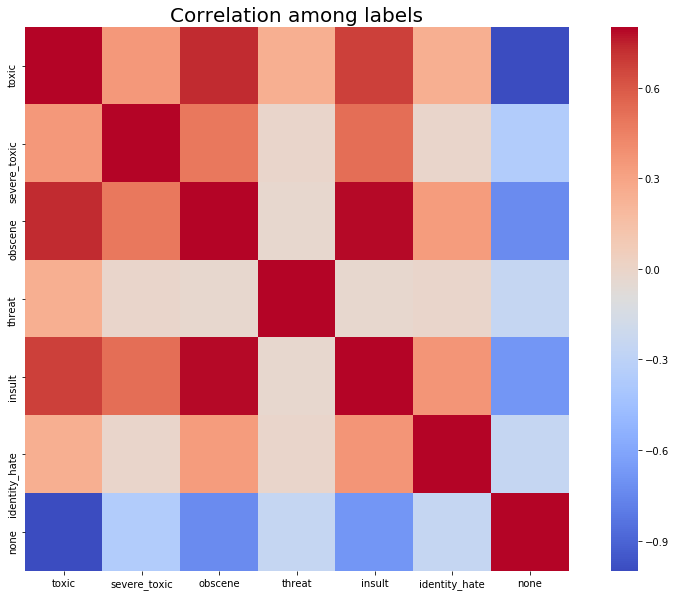

In [7]:
train.iloc[: ,2:].corr()

# Correlation matrix of labels
corrmat = train.iloc[: ,2:].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax = .8, square = True, cmap = 'coolwarm')
plt.title("Correlation among labels", size = 20)

plt.show()

In [8]:
print('Number of labels in each category:')
print(train.iloc[: ,2:].sum())
print('\nNumber of total training comments:')
print(len(train))

Number of labels in each category:
toxic            14
severe_toxic      2
obscene           8
threat            1
insult            7
identity_hate     1
none             87
dtype: int64

Number of total training comments:
101


## Data Cleaning

### Class imbalance issues:

We see that some labels are very rare in the training set.  

In [9]:
label_cols = train.iloc[: ,2:]
print("Relative abundance of labels within the training set:\n")
for col in label_cols:
    info = '{} :\t {}%\t({} total)'.format(
        col, 
        "%.1f" %( train[col].sum()/train.shape[0]*100), train[col].sum()) 
    print(info)

Relative abundance of labels within the training set:

toxic :	 13.9%	(14 total)
severe_toxic :	 2.0%	(2 total)
obscene :	 7.9%	(8 total)
threat :	 1.0%	(1 total)
insult :	 6.9%	(7 total)
identity_hate :	 1.0%	(1 total)
none :	 86.1%	(87 total)


In [10]:
# Balance each category by under-sampling the majority class  
def undersample(train, col):
    smallSampleClean = train[train[col] == 0].sample(train[col].sum())[['comment_text', col]]
    smallSampleDirty = train[train[col] == 1][['comment_text', col]]
    frames = [smallSampleClean, smallSampleDirty]
    newTrain = pd.concat(frames, axis = 0)
    newTrain.shape
   
    return newTrain


def test_undersample(train, col):
    print("Dimensions before undersampling for ", col, ": ", train.shape)
    newTrain = undersample(train, col)
    print("Dimensions after undersampling for ", col, ": ", newTrain.shape)
    
    if newTrain.shape[0] == 2*len(train[train[col] ==1 ]) and newTrain.shape[1] == 2:
        print("test passed")
    else: print("Error occurred in test_undersample")
test_undersample(train, 'threat') 


Dimensions before undersampling for  threat :  (101, 9)
Dimensions after undersampling for  threat :  (2, 2)
test passed


In [11]:
# Create a dictionary of the labels and their respective 

threat = undersample(train, 'threat')
toxic = undersample(train, 'toxic')
severe_toxic = undersample(train, 'severe_toxic')
obscene = undersample(train, 'obscene')
insult = undersample(train, 'insult')
identity_hate = undersample(train, 'identity_hate')

testSets = {'threat': threat,
           'toxic': toxic,
           'severe_toxic': severe_toxic,
            'obscene': obscene,
            'insult': insult,
            'identity_hate': identity_hate
           }


In [12]:
print("Undersampled abundance of labels within the training set:\n")
for test in testSets:    
    info = '{} : {}%\t({} total)'.format(
        test, "%.1f" %( testSets[test][test].sum()/len(testSets[test]))
                 , testSets[test][test].sum()) 
    print(info)

Undersampled abundance of labels within the training set:

threat : 0.5%	(1 total)
toxic : 0.5%	(14 total)
severe_toxic : 0.5%	(2 total)
obscene : 0.5%	(8 total)
insult : 0.5%	(7 total)
identity_hate : 0.5%	(1 total)


We now have a dictionary of balanced datasets, which has reduced the size of the training dataset by undersampling the majority class. 

## Clean the comment field

*Step 1: Remove numbers and bad characters. We feed the dataframe into the text_prepare method, which cleans out IP addresses, bad characters, and sets all words to lower case.* 

*For later improvement, it might be good to find and remove proper nouns from the training set. Because these comments come from Wikipedia pages where users are discussing a large range of topics, removing many of the proper nouns might help hone in on other words that may be more informative.*

*Including proper nouns may also cause overfitting to particular topics where many of the toxic comments are originating*

In [13]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|\\@,;]')
BAD_SYMBOLS_RE = re.compile('[^a-z #+_]') 

def text_prepare(text):
    text = text.lower()
    for ch in text:
        if REPLACE_BY_SPACE_RE.match(ch):
            text = text.replace(ch, " ")
        if BAD_SYMBOLS_RE.match(ch):
            text = text.replace(ch, '')
    return text

def test_text_prepare():
    examples = ['SQL Server -887.97equivalent']
    answers = ['sql server equivalent']
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            print(text_prepare(ex))
            return "Something's not quite right"
            
    return "Basic tests are passed"

print(test_text_prepare())

Basic tests are passed


In [14]:
# Normalize and clean the comment field by bringing all to lower case, removing IP addresses and other numerical fields, 
# and removing other non-letter characters. 
for test in testSets: 
    for comment in testSets[test].values:
        comment[0] = text_prepare(comment[0])
        

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokenizer = nltk.tokenize.TreebankWordTokenizer()
stemmer = nltk.stem.WordNetLemmatizer()

# We break up each comment into word tokens, then take the lemma (root word) of that token. 
for test in testSets: 
    for comment in testSets[test].values[:3]:
        print("Next\n\n\n", comment[0])
        tokens = tokenizer.tokenize(comment[0])
        print(tokens)
        comment[0] = " ".join(stemmer.lemmatize(token) for token in tokens)
        print(comment[0])
    print(testSets[test].values, '\n\n\n\n\n\n\n\n')

Next


 Bye! 

Don't look, come or think of comming back! Tosser.
['Bye', '!', 'Do', "n't", 'look', ',', 'come', 'or', 'think', 'of', 'comming', 'back', '!', 'Tosser', '.']
Bye ! Do n't look , come or think of comming back ! Tosser .
Next


 Hi! I am back again!
Last warning!
Stop undoing my edits or die!
['Hi', '!', 'I', 'am', 'back', 'again', '!', 'Last', 'warning', '!', 'Stop', 'undoing', 'my', 'edits', 'or', 'die', '!']
Hi ! I am back again ! Last warning ! Stop undoing my edits or die !
[["Bye! \n\nDon't look, come or think of comming back! Tosser." 0]
 ['Hi! I am back again!\nLast warning!\nStop undoing my edits or die!' 1]] 








Next


 "

 ""Mainland Asia"" includes ""the lower basin of China's Yangtze River"" as well as ""Korea"".  But being specific is fine too.  I just found a citation for a more comprehensive DNA study by Hammer below, rather than our generarizations and speculation so far. 

 Citation for ""Yayoi culture was brought to Japan by migrants from Korea, who

In [16]:
for x in train.index:    
    train.loc[x, 'comment_text'] = text_prepare(train.iloc[x]['comment_text'])


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
texts = train.loc[:]['comment_text']

In [18]:
tokenizer = nltk.tokenize.TreebankWordTokenizer()
stemmer = nltk.stem.WordNetLemmatizer()


for text in texts:
    print("Next\n\n\n", text)
    tokens = tokenizer.tokenize(text)
    print(tokens)
    train.loc[train['comment_text'] == text, 'comment_text'] = " ".join(stemmer.lemmatize(token) for token in tokens)
    print(" ".join(stemmer.lemmatize(token) for token in tokens))

Next


 explanationwhy the edits made under my username hardcore metallica fan were reverted they werent vandalisms  just closure on some gas after i voted at new york dolls fac and please dont remove the template from the talk page since im retired now
['explanationwhy', 'the', 'edits', 'made', 'under', 'my', 'username', 'hardcore', 'metallica', 'fan', 'were', 'reverted', 'they', 'werent', 'vandalisms', 'just', 'closure', 'on', 'some', 'gas', 'after', 'i', 'voted', 'at', 'new', 'york', 'dolls', 'fac', 'and', 'please', 'dont', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'im', 'retired', 'now']
explanationwhy the edits made under my username hardcore metallica fan were reverted they werent vandalism just closure on some gas after i voted at new york doll fac and please dont remove the template from the talk page since im retired now
Next


 daww he matches this background colour im seemingly stuck with thanks   talk    january     utc 
['daww', 'he', 'matches', 

hithanks for our kind word see you around talk
Next


 collusion in poker this is regarded as most heinous form of cheating in poker  perhaps some mention of this  or example  is warranted
['collusion', 'in', 'poker', 'this', 'is', 'regarded', 'as', 'most', 'heinous', 'form', 'of', 'cheating', 'in', 'poker', 'perhaps', 'some', 'mention', 'of', 'this', 'or', 'example', 'is', 'warranted']
collusion in poker this is regarded a most heinous form of cheating in poker perhaps some mention of this or example is warranted
Next


 thanks much  however  if its been resolved  why is it that today  when i didnt write anything in edit summary  camera put its ad in my edit summary boxequalvoice  talk 
['thanks', 'much', 'however', 'if', 'its', 'been', 'resolved', 'why', 'is', 'it', 'that', 'today', 'when', 'i', 'didnt', 'write', 'anything', 'in', 'edit', 'summary', 'camera', 'put', 'its', 'ad', 'in', 'my', 'edit', 'summary', 'boxequalvoice', 'talk']
thanks much however if it been resolved why is it 

In [ ]:
train.head(20)




## Strategic Approaches:

**Tokenize with 1-grams, 2-grams, 3-grams**

**Tokenize on stop words**

**Tokenize after casting all to lowercase**


**Approach 1:** Use TFIDF (Term Frequency * Inverse Doc Frequency on the Words in the Corpus. Use Logistic Regression, Naive Bayes. 

**Approach 2:** Use neural network at word level. 

**Approach 3:** Use neural network on character level. 


Compare results. 

In [ ]:
tfidf = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.4, ngram_range=(1,3))
features = tfidf.fit_transform(texts)

In [ ]:
sparseData = pd.DataFrame(features.todense(), columns = tfidf.get_feature_names())
sparseData.shape

In [ ]:
sparseData.head(100)

## Logistic Regression

In [ ]:
from sklearn import linear_model

In [ ]:
regr = linear_model.LinearRegression()
X = sparseData
#pred = regr.fit(sparseData, train[toxic])

In [ ]:
preds = pd.DataFrame()
for col in label_cols: 
    regr.fit(sparseData, train[col])
    print("\n\nCol:", col)
    #print('\nCoefficients: \n', regr.coef_)
    #print('\nIntercept: \n', regr.intercept_)
    print('\nR-squared:')
    print(regr.score(X, train[col]))

In [ ]:
from sklearn.model_selection import cross_val_score

regr = linear_model.LinearRegression()


for col in label_cols: 
    print("\n\nCol:", col)
    regr_score = cross_val_score(regr, X, train[col], cv=10)
    print("Cross-Validated R-Squared of Linear Regression Model: %0.2f (+/- %0.2f)" 
          % (regr_score.mean(), regr_score.std() * 2))

In [ ]:
sparseData.shape

In [ ]:
for col in label_cols:
    print(train[col].shape)

## Naive Bayes Classification


In [ ]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

for col in label_cols:
    # Fit our model to the data.
    bnb.fit(sparseData, train[col])

    # Classify, storing the result in a new variable.
    y_pred = bnb.predict(sparseData)

    # Display our results.
    print('\n\n\nColumn name: ', col)
    print("Number of mislabeled points out of a total {} points : {}".format(
        sparseData.shape[0],
        (train[col] != y_pred).sum()
    ))
    print(train[train[col] != y_pred]['comment_text'])
    print('mistakes: ', (train[col] != y_pred).sum())
    print('total in category: ', train[col].sum())
    print('percent missed: ', (train[col] != y_pred).sum() / train[col].sum())
    

In [ ]:
train[train['obscene'] != y_pred]